In [1]:
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np
from tf.transformations import euler_from_quaternion

## A test to make sure this is the correct way to compute the covariance
* This example was obtained through this link: https://www.cuemath.com/algebra/covariance-matrix/

In [2]:
x_data = np.array([15,35,20,14,28])
y_data = np.array([12.5,15.8,9.3,20.1,5.2])
z_data = np.array([50,55,70,65,80])
data = np.column_stack((x_data,y_data,z_data))
data

array([[15. , 12.5, 50. ],
       [35. , 15.8, 55. ],
       [20. ,  9.3, 70. ],
       [14. , 20.1, 65. ],
       [28. ,  5.2, 80. ]])

In [3]:
data_centered = data - np.mean(data)
cov_matrix = np.cov(data_centered,rowvar=False)
cov_matrix

array([[ 80.3  , -13.865,  14.25 ],
       [-13.865,  33.037, -39.525],
       [ 14.25 , -39.525, 142.5  ]])

## Computing the Covariance for the sensor data

* There are a total of 9 states
    * Vx
    * Vy
    * Vz
    * Ax
    * Ay
    * Az
    * Yaw
    * Yaw_dot
    * steering angle

* There is no sensor for linear velocity and steering angle, therefore, they are not considered in my coveriance matrix R

In [6]:
# Obtaining the data

bag = bagpy.bagreader('/home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/old_bags/stationary_2024-04-16-17-42-55.bag')
imu_topic_data = pd.read_csv(bag.message_by_topic('/Imu'))
imu_accelrations = [imu_topic_data['linear_acceleration.x'], imu_topic_data['linear_acceleration.y'], imu_topic_data['linear_acceleration.z']]
imu_angular = [imu_topic_data['angular_velocity.z']]
imu_orientation = [imu_topic_data['orientation.x'], imu_topic_data['orientation.y'], imu_topic_data['orientation.z'], imu_topic_data['orientation.w']]

[INFO]  Data folder /home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/old_bags/stationary_2024-04-16-17-42-55 already exists. Not creating.


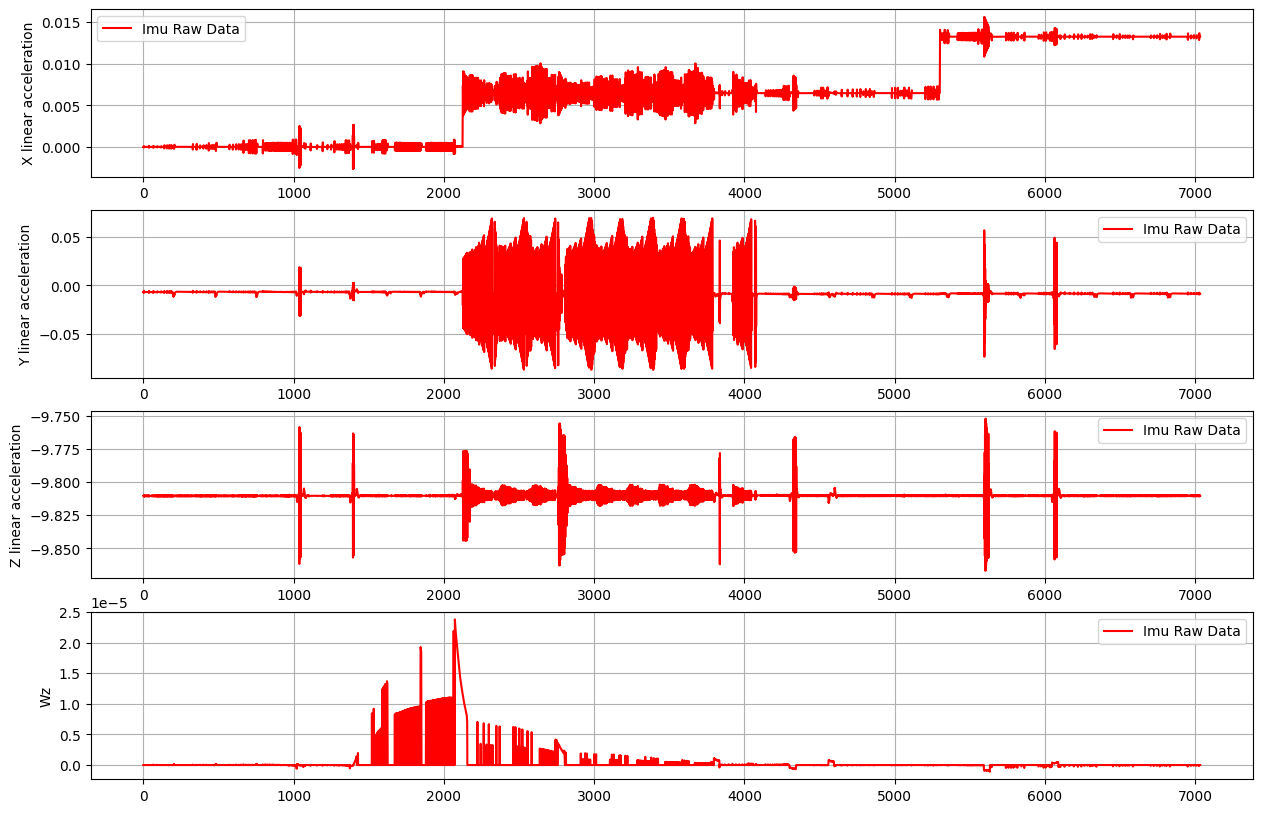

In [13]:
# Making sure the correct data was obtained through plotting it
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
for i, ax in enumerate(axes):
    if i<3:
        ax.plot(range(len(imu_accelrations[i])), imu_accelrations[i], label='Imu Raw Data', color='red')
        axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
        ax.set_ylabel(f'{axis} linear acceleration')
        ax.legend()
        ax.grid()

axes[3].plot(range(len(imu_angular[0])), imu_angular[0], label='Imu Raw Data', color='red')
axes[3].set_ylabel("Wz")
axes[3].legend()
axes[3].grid()

plt.show()

In [14]:
# Extracting the sensor data

x_acc = imu_accelrations[0].values
y_acc = imu_accelrations[1].values
z_acc = imu_accelrations[2].values

yaw_data = np.zeros_like(imu_accelrations[1].values)
yaw_dot_data =  imu_angular[0].values

# Converting the orientation from quaternion to euler and extracting the yaw

for i in range(len(yaw_data)):
    yaw_data[i] = euler_from_quaternion((imu_orientation[0][i], imu_orientation[1][i], imu_orientation[2][i], imu_orientation[3][i]))[2]

In [15]:
# Computing the Covariance

sensor_data = np.column_stack((x_acc, y_acc, z_acc, yaw_data, yaw_dot_data))
sensor_data_centered = sensor_data - np.mean(sensor_data)
sensor_cov_matrix = np.cov(sensor_data_centered,rowvar=False)

In [16]:
# Cleaning Up the data to remove values that are less than 1e-20
threshold = 1e-20
for i, rows in enumerate(sensor_cov_matrix):
    for j, cols in enumerate(rows):
        sensor_cov_matrix[(i,j)] = sensor_cov_matrix[(i,j)] if abs(sensor_cov_matrix[(i,j)])>threshold else 0

In [17]:
# Displaying the data in the form of a dataframe for it to be more readable

df = pd.DataFrame(sensor_cov_matrix)
df

,0,1,2,3,4
0,2.427458e-05,-1.669918e-05,6.829418e-07,6.240109e-08,-2.451355e-09
1,-1.669918e-05,4.997876e-04,2.045260e-05,-1.338288e-08,8.412110e-11
2,6.829418e-07,2.045260e-05,4.234005e-05,1.572766e-09,-3.898079e-11
3,6.240109e-08,-1.338288e-08,1.572766e-09,2.385820e-10,-3.818944e-12
4,-2.451355e-09,8.412110e-11,-3.898079e-11,-3.818944e-12,5.429372e-12


In [30]:
roll = []
pitch = []
yaw = []

for i in range(len(yaw_data)):
    euler_angles = euler_from_quaternion((imu_orientation[0][i], imu_orientation[1][i], imu_orientation[2][i], imu_orientation[3][i]))
    roll.append(euler_angles[0])
    pitch.append(euler_angles[1])
    yaw.append(euler_angles[2])

euler_angles = np.array([roll,pitch,yaw])

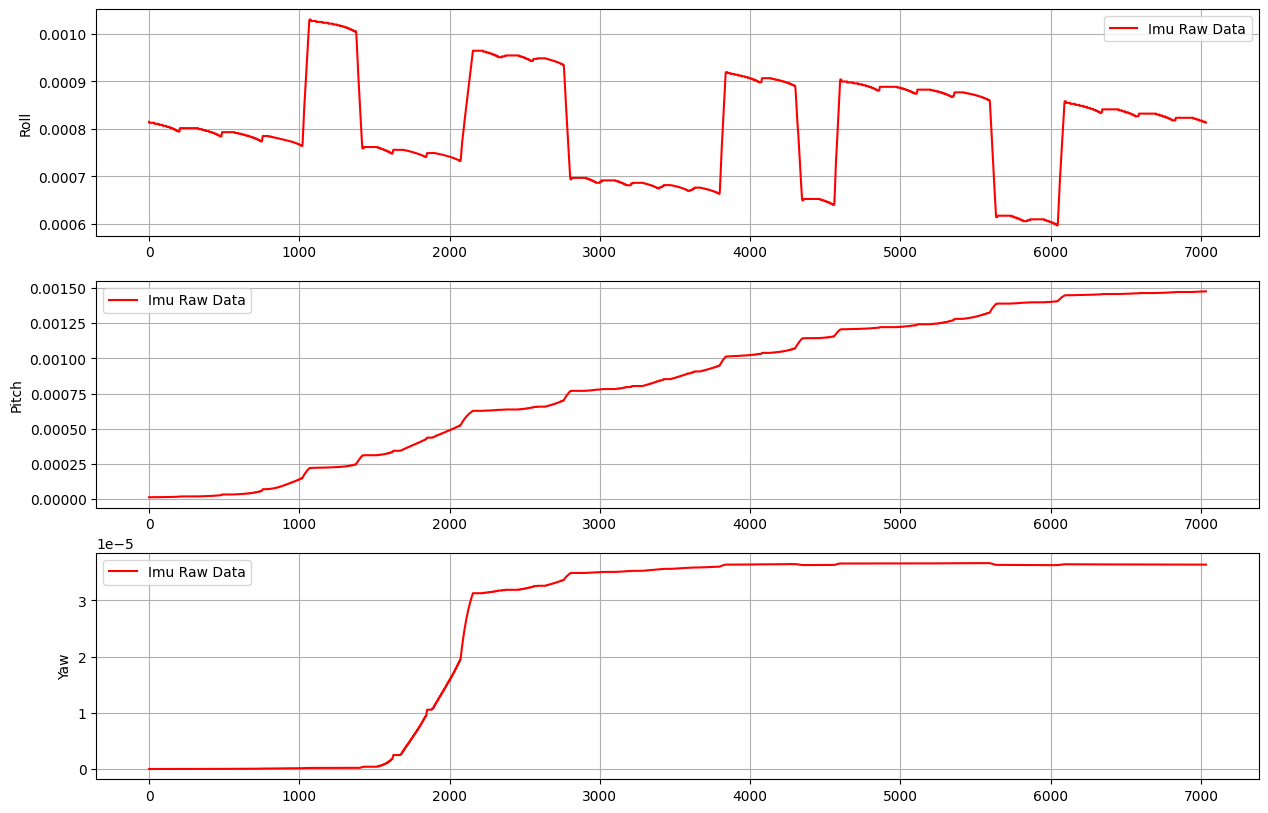

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
for i, ax in enumerate(axes):
    ax.plot(range(len(euler_angles[i])), euler_angles[i], label='Imu Raw Data', color='red')
    axis = 'Roll' if i==0 else ('Pitch' if i==1 else 'Yaw')
    ax.set_ylabel(f'{axis}')
    ax.legend()
    ax.grid()

plt.show()

In [32]:
from tf.transformations import euler_matrix, quaternion_matrix
R = euler_matrix(roll[0],pitch[0],yaw[0])[:-1,:-1]
R_q = quaternion_matrix((imu_orientation[0][0], imu_orientation[1][0], imu_orientation[2][0], imu_orientation[3][0]))[:-1,:-1]
print(R)
print()
print(R_q)

# This means that i don't really need to allign the imu with the body frame for it is already aligned

[[ 1.00000000e+00 -2.75117055e-08  1.21726343e-05]
 [ 3.74328056e-08  9.99999668e-01 -8.15033874e-04]
 [-1.21726078e-05  8.15033875e-04  9.99999668e-01]]

[[ 1.00000000e+00 -2.75117055e-08  1.21726343e-05]
 [ 3.74328056e-08  9.99999668e-01 -8.15033874e-04]
 [-1.21726078e-05  8.15033875e-04  9.99999668e-01]]


In [33]:
X_matrix = np.array([[0],
                  [1],
                  [2],
                  [3],
                  [4],
                  [5],
                  [6]])

X_matrix[-1,0]

6

In [15]:
bag = bagpy.bagreader('/home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/straight_line_new_2024-03-19-15-23-04.bag')
bag.topic_table

[INFO]  Data folder /home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/straight_line_new_2024-03-19-15-23-04 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/Imu,sensor_msgs/Imu,1053,59.947318
1,/Imu_filtered,geometry_msgs/Vector3,1053,60.005208
2,/SteeringAngle,std_msgs/Float64,1756,99.969110
3,/clock,rosgraph_msgs/Clock,1053,59.956315
4,/cmd_vel,std_msgs/Float64,1755,99.976259
5,/current_heading,std_msgs/Float64,1053,59.993192
6,/current_linear_velocity,geometry_msgs/Vector3,1053,60.010359
7,/odom,nav_msgs/Odometry,1053,59.950317
8,/orientation,geometry_msgs/Quaternion,1053,59.999628
9,/path_planner/trajectory,std_msgs/Float32MultiArray,1,NaN
